In [ ]:

import sys
sys.executable
sys.path
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts\\site-packages')
#C:\Users\siptest\AppData\Roaming\Python\Python36\site-packages

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#from tqdm.notebook imporcd t tqdm
from joblib import Parallel, delayed

from scipy.stats import entropy, norm
from scipy.integrate import quad

from proglearn.proglearn.forest import UncertaintyForest



In [ ]:
from hyppo.sims import ksample_sim
from hyppo.ksample._utils import k_sample_transform
from hyppo.sims import *


In [ ]:
#modified code to use ProgLearn's UF 
def estimate_ce(X, y): 
    frac_eval = 0.3
    uf = UncertaintyForest(n_estimators = 300, kappa = 3.0, tree_construction_proportion=0.4)
    
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
    uf.fit(X_train, y_train.ravel())
    p = uf.predict_proba(X_eval)
    return np.mean(entropy(p.T, base = np.exp(1)))

In [4]:
MAX_SAMPLE_SIZE = 100
#STEP_SIZE = 5
STEP_SIZE = 20
SAMP_SIZES = range(20, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
#SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 20

In [ ]:
def test(): 
    nullDist = []
    success= 0
    for i in range(1000): 
        temp = []
        success = np.random.binomial(1000, 0.5)
        temp.append(success/1000)
        temp.append((1000-success)/1000)
        nullDist.append(entropy(temp, base = np.exp(1)))
    print(nullDist)
    
    matrix1, matrix2 = ksample_sim.trans_2samp(multimodal_independence, 500, 1, noise=False, trans=0.3)
    x, y = k_sample_transform([matrix1, matrix2])
    ce = estimate_ce(x, y)
    #to calculate p-value, get proportion of null greater then ce from UF 
    pvalue = (nullDist >= ce).sum() / 1000
    
    return nullDist, ce, pvalue

In [ ]:
power = []
for x in SAMP_SIZES:
    pvalues = []
    num = 0; 
    for p in range(POWER_REPS): 
        null_Dist, test_stat, p_val = test()
        pvalue = (null_Dist >= test_stat).sum() / 1000
        pvalues.append(pvalue)
    for pval in pvalues: 
        if pval >= 0.05: 
            num=num+1
    power.append(num/ POWER_REPS)

np.savetxt('C:/Users/siptest/Desktop/hyppo/benchmarks/2samp_vs_samplesize/UF_MultiModal_NotNull.csv',
               power, delimiter=',')    


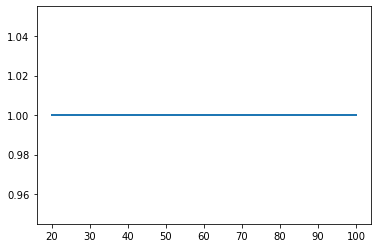

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plot = np.genfromtxt('C:/Users/siptest/Desktop/hyppo/benchmarks/2samp_vs_samplesize/UF_MultiModal_NotNull.csv', delimiter=',')    

plt.plot(SAMP_SIZES, plot, lw=2)